# 1. Import Dependencies

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
!pip install mss pydirectinput pytesseract ipywidgets

In [ ]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

# 2. Build Environment

2.1 Create Environment

In [71]:
class WebGame(Env):
    # Setup the environment action and observation shapes
    def __init__(self):
        # Subclass model
        super().__init__()
        # Setup spaces (Gives a multi dimensional array as return value --> 1 batch, 83 high 100 wide, box can take many shapes, images, timeseries data etc. data type is uint8 which is small and compressed
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        # Will have three actions, jump, down, no operation
        self.action_space = Discrete(3)
        # Define extraction parameters for the game, mss is a screenshot module
        self.cap = mss()
        self.game_location = {
            'top': 500, 
            'left': 0, 
            'width': 840, 
            'height': 700
        }
        self.done_location = {
            'top': 550, 
            'left': 790, 
            'width': 960, 
            'height': 160
        }
    
    # What is called to do something in the game
    def step(self, action):
        # Action key - 0 = space, 1 = down, 2 = no operation
        actions = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        
        if action != 2:
            pydirectinput.press(actions[action])
        
        # Check if game is over
        done, done_cap = self.get_done()
        # Get next observation
        new_observation = self.get_observation()
        
        # Reward (get a point for every frame alive)
        reward = 1
        # Info dictionary (stable baselines expects this
        info = {}
        
        return new_observation, reward, done, info
        
    # Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        
        # Give time to render
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Restarting the game
    def reset(self):
        time.sleep(1)
        # Doesn't really matter where you click
        pydirectinput.click(x=250, y=250)
        pydirectinput.press('space')
        return self.get_observation()
    
    # Close down the observation
    def close(self):
        cv2.destroyAllWindows()
    
    # Get the part of the game that we want
    def get_observation(self):
        # Get screen capture of game, can specify channels and datatype at the end
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100, 83))
        # Add channels first
        channel = np.reshape(resized, (1, 83, 100))
        
        return channel
    
    # Get the game finished text
    def get_done(self):
        # Get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3].astype(np.uint8)
        # Valid game finished text (font makes the M look kind of like an H)
        # pytesseract.image_to_string(done_cap) gives GAME OY ER\n' that's why we don't parse the entire text
        done_strings = ['GAME', 'GAHE']
        
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True

        return done, done_cap
        

In [72]:
env = WebGame()

In [73]:
env.reset()

array([[[33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        ...,
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33]]], dtype=uint8)

In [77]:
env.close()

In [75]:
env.render()

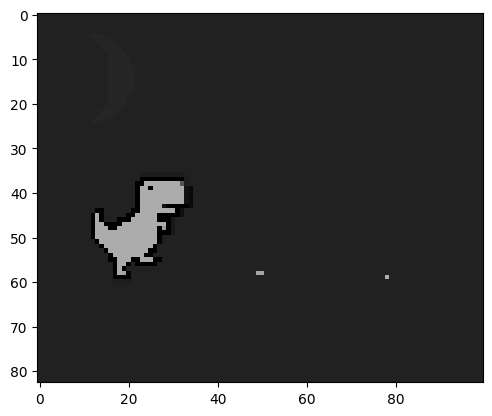

In [76]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [78]:
done, done_capture = env.get_done()

In [79]:
done

True

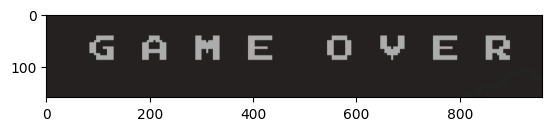

In [80]:
plt.imshow(done_capture)

In [55]:
env.action_space.sample()

In [56]:
plt.imshow(env.observation_space.sample()[0])

2.2 Test Environment

In [57]:
env = WebGame()

In [58]:
obs = env.get_observation()

In [59]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [60]:
done, done_capture = env.get_done()

In [61]:
print(done)

In [62]:
plt.imshow(done_capture)

In [ ]:
# Test 10 times
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    
    print(f'Total Reward for episode {episode} is {total_reward}')

# 3. Train Model

3.1 Create Callback

In [63]:
# Import os for file path management
import os
# Import base callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check environment
from stable_baselines3.common import env_checker

In [64]:
# Check that environment is ok
env_checker.check_env(env)

In [ ]:
# Save model in train directory
class TrainAndLogCallback(BaseCallback):
    
    def __init__(self,check_freq, save_path, verbose=1):
        super(TrainAndLogCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
        
        return True

In [65]:
CHECKPOINT_DIR = './train/'
LOG_DIR =  './logs/'

In [66]:
# Save every 1000 steps (1000 frames)
callback = TrainAndLogCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

3.2 Build DQN and train

In [67]:
# Deep Q Network builds on Fitted Q-iteration (FQI) and makes use of different tricks to stablize the learning with neural networks: it uses a replay buffer, a target network and gradient clipping
from stable_baselines3 import DQN

In [69]:
# Create the DQN model
# We use CnnPolicy because we are passing through a captured observation
# Optimize buffer size based on RAM
# Can optimize when the learning starts as well (lower to get the model to start training faster)
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=400000, learning_starts=1000)

In [70]:
# Start training
# Higher training time will give smoother results
model.learn(total_timesteps=6000, callback=callback)

# 4. Test Model

In [44]:
# model = DQN.load(os.path.join(dir, folder_name))

In [ ]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    
    print(f'Total reward for episode {episode} is {total_reward}')
    time.sleep(2)